In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import pickle


In [ ]:
df = pd.read_csv("telecom_data_usage_unclean.csv")
df.head()


,customer_id,customer_age,monthly_recharge,call_minutes,sms_count,support_calls,internet_speed_mbps,roaming_usage_gb,tenure_months,device_type,plan_type,network_type,region,payment_method,monthly_data_usage
0,1,63.0,1586.0,179.0,527,12,200,10.055382,7,Other,Prepaid,4G,West,UPI,95.865572
1,2,20.0,2305.0,832.0,432,14,40,7.234529,82,iOS,Postpaid,3G,North,Cash,49.234637
2,3,41.0,116.0,1898.0,281,10,10,12.664142,12,Android,Prepaid,5G,North,UPI,54.422365
3,4,19.0,NaN,956.0,274,10,100,4.921213,97,Other,Prepaid,3G,West,Cash,78.667196
4,5,35.0,1469.0,1359.0,131,0,40,12.686571,28,iOS,Postpaid,3G,South,Card,45.162448


In [64]:
df.shape


(1340, 15)

In [65]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          1340 non-null   int64  
 1   customer_age         1273 non-null   float64
 2   monthly_recharge     1271 non-null   float64
 3   call_minutes         1274 non-null   float64
 4   sms_count            1340 non-null   int64  
 5   support_calls        1340 non-null   int64  
 6   internet_speed_mbps  1340 non-null   int64  
 7   roaming_usage_gb     1340 non-null   float64
 8   tenure_months        1340 non-null   int64  
 9   device_type          1269 non-null   object 
 10  plan_type            1340 non-null   object 
 11  network_type         1340 non-null   object 
 12  region               1272 non-null   object 
 13  payment_method       1340 non-null   object 
 14  monthly_data_usage   1340 non-null   float64
dtypes: float64(5), int64(5), object(5)
mem

In [66]:
df.describe()


,customer_id,customer_age,monthly_recharge,call_minutes,sms_count,support_calls,internet_speed_mbps,roaming_usage_gb,tenure_months,monthly_data_usage
count,1340.000000,1273.000000,1271.000000,1274.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,652.005224,42.432836,1319.192762,986.354788,350.402985,7.016418,71.835821,7.589907,58.847761,47.913225
std,375.030951,15.494433,709.990406,586.811481,201.833712,4.385941,69.367590,4.336253,35.207578,34.637076
min,1.000000,16.000000,101.000000,0.000000,0.000000,0.000000,10.000000,0.001714,1.000000,-26.013205
25%,327.750000,29.000000,704.000000,465.000000,179.750000,3.000000,20.000000,3.971393,27.000000,29.644908
50%,653.500000,43.000000,1334.000000,983.500000,349.500000,7.000000,40.000000,7.541409,60.000000,44.501487
75%,975.250000,56.000000,1936.500000,1483.500000,519.250000,11.000000,100.000000,11.528449,89.000000,60.539085
max,1300.000000,69.000000,2499.000000,1999.000000,699.000000,14.000000,200.000000,14.997541,119.000000,471.214806


In [67]:
df = df.drop_duplicates()


In [68]:
df['customer_age'].fillna(df['customer_age'].median(), inplace=True)
df['monthly_recharge'].fillna(df['monthly_recharge'].median(), inplace=True)
df['call_minutes'].fillna(df['call_minutes'].median(), inplace=True)

df['device_type'].fillna(df['device_type'].mode()[0], inplace=True)
df['region'].fillna(df['region'].mode()[0], inplace=True)


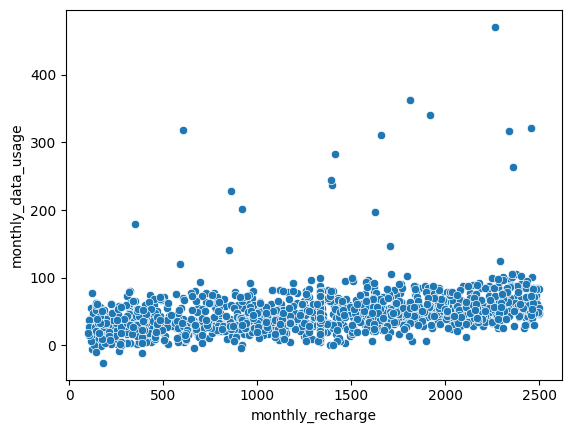

In [69]:
sns.scatterplot(x='monthly_recharge', y='monthly_data_usage', data=df)
plt.show()


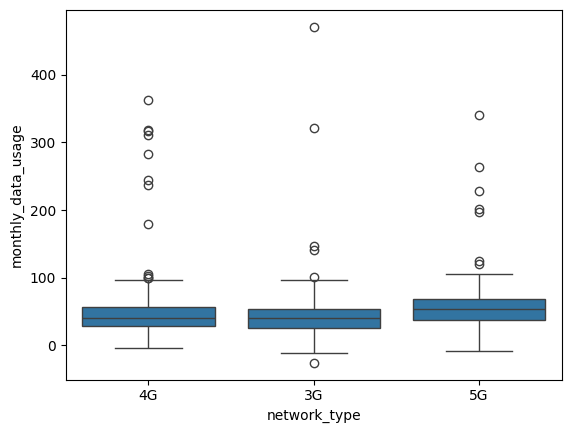

In [70]:
sns.boxplot(x='network_type', y='monthly_data_usage', data=df)
plt.show()


In [71]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
num_cols


Index(['customer_id', 'customer_age', 'monthly_recharge', 'call_minutes',
       'sms_count', 'support_calls', 'internet_speed_mbps', 'roaming_usage_gb',
       'tenure_months', 'monthly_data_usage'],
      dtype='object')

In [72]:
def treat_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = df[column].clip(lower_bound, upper_bound)
    return df


In [73]:
for col in num_cols:
    if col not in ["customer_id"]:
        df = treat_outliers_iqr(df, col)


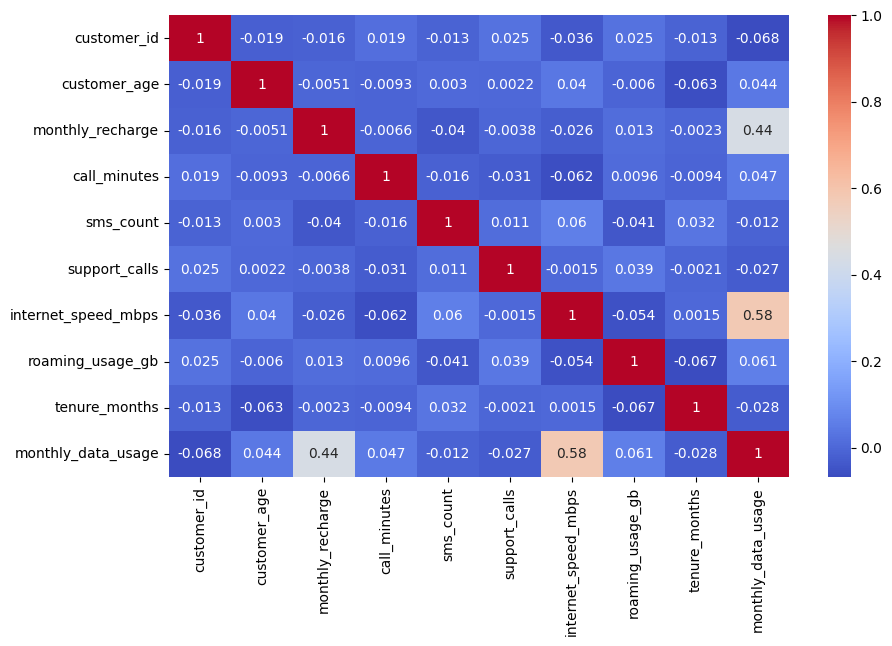

In [74]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()


Feature-Target Split

In [75]:
X = df.drop(columns=[
    "monthly_data_usage",
    "customer_id",
    "payment_method"
])
y = df["monthly_data_usage"]


In [76]:
X = pd.get_dummies(X, drop_first=True)


Train–Test Split

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [78]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


**REGRESSION MODELS**

Linear Regression

In [79]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


RANDOM FOREST REGRESSOR

In [80]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)
rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

Gradient Boosting Regressor

In [81]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)


,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft 

MODEL EVALUATION

In [82]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate(model, name):
    preds = model.predict(X_test)
    print(name)
    print("MAE:", mean_absolute_error(y_test, preds))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
    print("R2:", r2_score(y_test, preds))
    print("-" * 30)

evaluate(lr, "Linear Regression")
evaluate(rf, "Random Forest")
evaluate(gb, "Gradient Boosting")


Linear Regression
MAE: 10.412934260009632
RMSE: 14.536388379806766
R2: 0.6085241720478601
------------------------------
Random Forest
MAE: 11.450945420182903
RMSE: 15.490603256850664
R2: 0.5554418488466673
------------------------------
Gradient Boosting
MAE: 10.945260190533896
RMSE: 14.86634608547
R2: 0.590550454500447
------------------------------


Saving the Model

In [83]:
import pickle

# 1. Save model
with open("linear_regression_model.pkl", "wb") as f:
    pickle.dump(lr, f)

# 2. Save scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# 3. Save column names (after get_dummies)
with open("columns.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)
